In [1]:
from matplotlib import pyplot as plt
import cv2
import imutils
import numpy as np

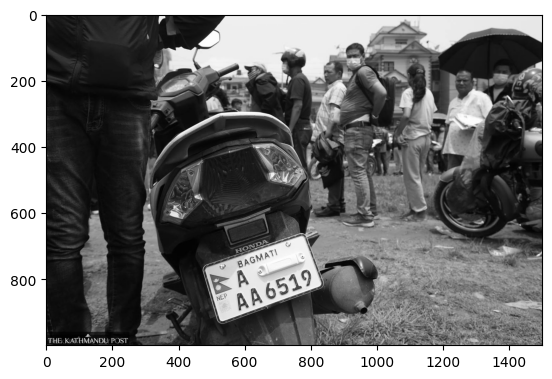

In [2]:
img = cv2.imread('image5.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

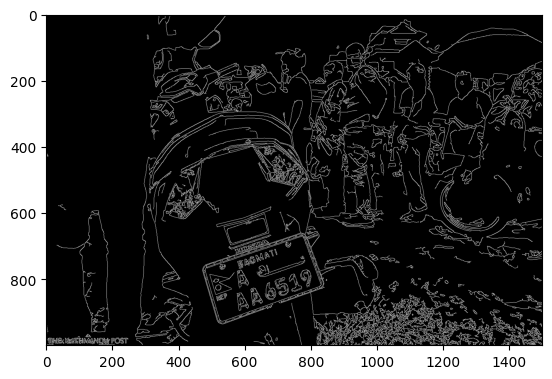

In [3]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [4]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]


In [5]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [6]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

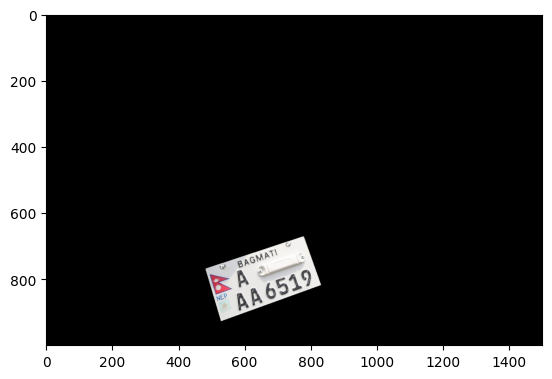

In [7]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))


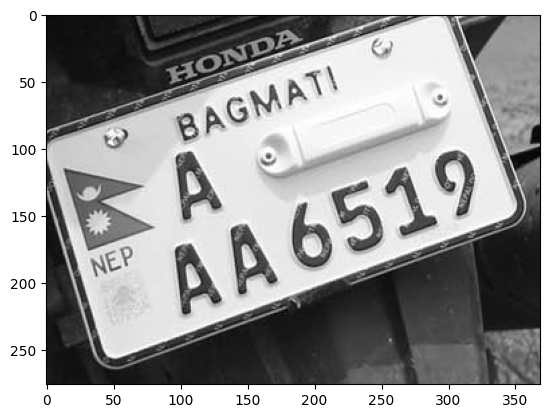

In [19]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+20, y1:y2+20]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))


TypeError: Image data of dtype object cannot be converted to float

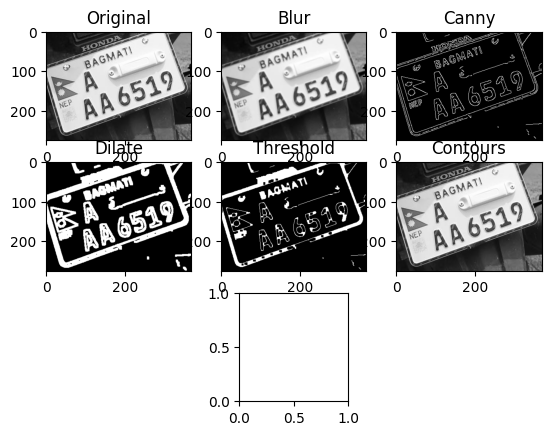

In [22]:
def order_points(pts):
    # Step 1: Find centre of object
    center = np.mean(pts)

    # Step 2: Move coordinate system to centre of object
    shifted = pts - center

    # Step #3: Find angles subtended from centroid to each corner point
    theta = np.arctan2(shifted[:, 0], shifted[:, 1])

    # Step #4: Return vertices ordered by theta
    ind = np.argsort(theta)
    return pts[ind]

def getContours(img, orig):  # Change - pass the original image too
    biggest = np.array([])
    maxArea = 0
    imgContour = orig.copy()  # Make a copy of the original image to return
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    index = None
    for i, cnt in enumerate(contours):  # Change - also provide index
        area = cv2.contourArea(cnt)
        if area > 500:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt,0.02*peri, True)
            if area > maxArea and len(approx) == 4:
                biggest = approx
                maxArea = area
                index = i  # Also save index to contour

    warped = None  # Stores the warped license plate image
    if index is not None: # Draw the biggest contour on the image
        cv2.drawContours(imgContour, contours, index, (255, 0, 0), 3)

        src = np.squeeze(biggest).astype(np.float32) # Source points
        height = image.shape[0]
        width = image.shape[1]
        # Destination points
        dst = np.float32([[0, 0], [0, height - 1], [width - 1, 0], [width - 1, height - 1]])
        # dst = np.float32([])
        # dst = np.float32([[0, 0], [0, img_shape[0] - 1], [img_shape[1] - 1, 0], [img_shape[1] - 1, img_shape[0] - 1]])   
        # Order the points correctly
        biggest = order_points(src)
        dst = order_points(dst)

        # Get the perspective transform
        M = cv2.getPerspectiveTransform(src, dst)

        # Warp the image
        img_shape = (width, height)
        warped = cv2.warpPerspective(orig, M, img_shape, flags=cv2.INTER_LINEAR)

    return biggest, imgContour, warped  # Change - also return drawn image

kernel = np.ones((3,3))
# plt.imshow()
# feeding our image from previous outputs
image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
imgCanny = cv2.Canny(imgBlur,150,200)
imgDial = cv2.dilate(imgCanny,kernel,iterations=2)
imgThres = cv2.erode(imgDial,kernel,iterations=2)
biggest, imgContour, warped = getContours(imgThres, image)  # Change

titles = ['Original', 'Blur', 'Canny', 'Dilate', 'Threshold', 'Contours', 'Warped']  # Change - also show warped image
images = [image[...,::-1],  imgBlur, imgCanny, imgDial, imgThres, imgContour, warped]  # Change

# Change - Also show contour drawn image + warped image
for i in range(5):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])

plt.subplot(3, 3, 6)
plt.imshow(images[-2])
plt.title(titles[-2])

plt.subplot(3, 3, 8)
plt.imshow(images[-1])
plt.title(titles[-1])

plt.show()